In [ ]:
!pip install -q openai rasterio folium matplotlib numpy pandas geopandas earthpy ee google-cloud google-auth google-auth-oauthlib google-auth-httplib2
!pip install -q ipyleaflet geemap

In [ ]:
!pip install geopandas fiona lxml

In [ ]:
!pip uninstall -y earthengine-api
!pip install earthengine-api --upgrade

Found existing installation: earthengine-api 1.5.19
Uninstalling earthengine-api-1.5.19:
  Successfully uninstalled earthengine-api-1.5.19
  Using cached earthengine_api-1.5.19-py3-none-any.whl.metadata (2.1 kB)
Using cached earthengine_api-1.5.19-py3-none-any.whl (462 kB)


In [ ]:
import ee
import geemap
import rasterio
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import openai
from PIL import Image
import io
import requests
from bs4 import BeautifulSoup
import geopandas as gpd
ee.Authenticate()

True

In [ ]:
ee.Initialize(project = 'massive-haiku-440107-q8')

In [ ]:
def setup_ee():
    import ee
    try:
        ee.Initialize()
    except Exception as e:
        print("Authenticating Earth Engine...")
        ee.Authenticate()
        ee.Initialize()

In [ ]:
import fiona

layers = fiona.listlayers("/content/amazon_geoglyphs.kml")
print("Available layers:\n")
for layer in layers:
    try:
        gdf = gpd.read_file("/content/amazon_geoglyphs.kml", driver="KML", layer=layer)
        print(f"✔️  {layer}: {len(gdf)} features, Geometry type: {gdf.geometry.geom_type.unique()}")
    except Exception as e:
        print(f"❌  {layer}: Error - {e}")


Available layers:

✔️  zanjas: 21 features, Geometry type: ['Point' 'LineString']
✔️  lidar located earthworks: 28 features, Geometry type: ['Point']
✔️  geoglyphs?: 41 features, Geometry type: ['Point']
❌  geoglyphs: Error - IllegalArgumentException: point array must contain 0 or >1 elements

✔️  mound villages?: 24 features, Geometry type: ['Point']
✔️  rondonia: 15 features, Geometry type: ['LineString']
✔️  mound sites: 78 features, Geometry type: ['Point']
✔️  mound villages: 4 features, Geometry type: ['Point']
✔️  small geoglyphs: 16 features, Geometry type: ['Point']
✔️  Xingu area lidar located earthworks: 11 features, Geometry type: ['Point']
✔️  geoglyphs (#2): 77 features, Geometry type: ['Point']
✔️  outlines: 75 features, Geometry type: ['LineString']
✔️  lines: 69 features, Geometry type: ['LineString']
✔️  lines (#2): 1775 features, Geometry type: ['LineString']
❌  outlines (#2): Error - IllegalArgumentException: point array must contain 0 or >1 elements

✔️  2025: 13 f

In [ ]:
# ## 2. Data Loading from Provided Sources
# Function to load datasets from provided academic papers
def load_archaeological_data_from_kml(kml_path, layer_name):
    try:
        gdf = gpd.read_file(kml_path, driver='KML', layer=layer_name)
        print(f"Loaded layer: {layer_name}")
    except Exception as e:
        print("Failed to load KML file:", e)
        return None

    # Convert non-point geometries to centroids
    if not all(gdf.geometry.geom_type == 'Point'):
        gdf['geometry'] = gdf.geometry.centroid

    gdf['lat'] = gdf.geometry.y
    gdf['lon'] = gdf.geometry.x

    gdf['type'] = gdf['Name'] if 'Name' in gdf.columns else 'unknown'

    return gdf[['Name', 'lat', 'lon', 'type']].rename(columns={'Name': 'name'})


In [ ]:
arch_df = load_archaeological_data_from_kml("/content/amazon_geoglyphs.kml", "geoglyphs (#2)")
arch_df.head()

Loaded layer: geoglyphs (#2)


,name,lat,lon,type
0,aparz,-9.723891,-57.172864,aparz
1,apiaz,-9.179501,-57.423948,apiaz
2,apiza,-9.227699,-57.700995,apiza
3,aripz,-9.350001,-59.322632,aripz
4,banc2,-9.872272,-57.771532,banc2


In [ ]:
# ## 3. Satellite Imagery Analysis
# Using Google Earth Engine with Sentinel-2
def get_sentinel_image(lat, lon, start_date='2020-01-01', end_date='2020-12-31'):
    point = ee.Geometry.Point(lon, lat)
    collection = (ee.ImageCollection('COPERNICUS/S2_SR')
                  .filterBounds(point)
                  .filterDate(start_date, end_date)
                  .sort('CLOUDY_PIXEL_PERCENTAGE')
                  .first())

    # True color visualization
    vis_params = {
        'min': 0,
        'max': 3000,
        'bands': ['B4', 'B3', 'B2']
    }

    return collection, vis_params

In [ ]:
# Example: Get image for a known archaeological site
collection, vis_params = get_sentinel_image(-4.25, -56.12)
Map = geemap.Map()
Map.addLayer(collection, vis_params, 'Sentinel-2')
Map.setCenter(-56.12, -4.25, 12)
Map

/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


Map(center=[-4.25, -56.12], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

In [ ]:
# ## 4. LIDAR Data Processing

# Function to analyze LIDAR data (using OpenTopography as mentioned)
def analyze_lidar(bbox):
    # In practice, you would download LIDAR data from OpenTopography
    # This is a placeholder for the actual analysis
    print(f"Analyzing LIDAR data for bounding box: {bbox}")

    # Simulated elevation anomalies
    np.random.seed(42)
    x = np.linspace(bbox[0], bbox[2], 100)
    y = np.linspace(bbox[1], bbox[3], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.sin(X*10) + np.cos(Y*10)  # Simulated terrain

    # Plot simulated anomalies
    plt.figure(figsize=(10, 8))
    plt.contourf(X, Y, Z, levels=20, cmap='terrain')
    plt.colorbar(label='Elevation (m)')
    plt.title('Simulated LIDAR Elevation Data with Potential Structures')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

Analyzing LIDAR data for bounding box: [-56.5, -4.5, -55.5, -3.5]


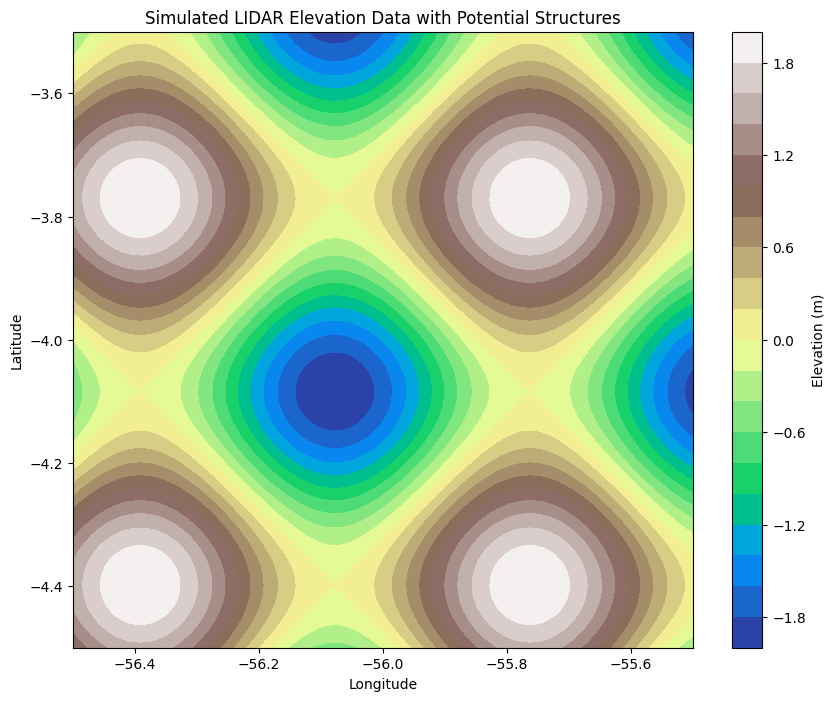

In [ ]:
# Example analysis
analyze_lidar([-56.5, -4.5, -55.5, -3.5])  # Santarém region

In [ ]:
!pip install selenium
!pip install undetected-chromedriver

In [ ]:
historical_text = """
From the 1743 Jesuit diary: "We found stone structures arranged in circles near the
confluence of the Tapajós and Amazon rivers, approximately three days upriver from Santarém."
"""

prompt = f"""
You are an archaeological AI assistant.

Task: Extract any **geographic descriptions**, **named places**, or **coordinates** from the following historical diary entry. If no coordinates are given, try to **infer likely locations** based on descriptions.

Text: {historical_text}
"""
print(prompt)



You are an archaeological AI assistant.

Task: Extract any **geographic descriptions**, **named places**, or **coordinates** from the following historical diary entry. If no coordinates are given, try to **infer likely locations** based on descriptions.

Text: 
From the 1743 Jesuit diary: "We found stone structures arranged in circles near the
confluence of the Tapajós and Amazon rivers, approximately three days upriver from Santarém."




In [ ]:

gpt_output = """
The stone structures were found near the confluence of the Tapajós and Amazon rivers.
This corresponds to modern-day Santarém, Brazil. The phrase 'three days upriver' suggests
a location southwest of Santarém, possibly near the village of Alter do Chão (~-54.95, -2.52).
"""

In [ ]:
def create_findings_map(archaeological_sites, potential_sites):
    # Set default center based on average known site location
    if not archaeological_sites.empty:
        center_lat = archaeological_sites['lat'].mean()
        center_lon = archaeological_sites['lon'].mean()
    else:
        center_lat, center_lon = -4, -55  # fallback

    m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

    # Add known archaeological sites
    for _, row in archaeological_sites.iterrows():
        if pd.notnull(row['lat']) and pd.notnull(row['lon']):
            folium.Marker(
                location=[row['lat'], row['lon']],
                popup=f"Known: {row.get('name', 'Unknown')} ({row.get('type', 'N/A')})",
                icon=folium.Icon(color='blue', icon='info-sign')
            ).add_to(m)

    # Add potential new sites
    for site in potential_sites:
        lat = site.get('lat')
        lon = site.get('lon')
        name = site.get('name', 'Unnamed Site')

        if lat is not None and lon is not None:
            folium.Marker(
                location=[lat, lon],
                popup=f"Potential: {name}",
                icon=folium.Icon(color='red', icon='star')
            ).add_to(m)

    return m


In [ ]:
archaeological_sites = pd.DataFrame([
    {"name": "Site A", "type": "Earthwork", "lat": -3.7, "lon": -55.1},
    {"name": "Site B", "type": "Geoglyph", "lat": -4.1, "lon": -55.7}
])

potential_sites = [
    {"name": "Suspected Circle", "lat": -3.85, "lon": -55.3},
    {"name": "Unmapped Structure", "lat": -4.05, "lon": -55.6}
]

m = create_findings_map(archaeological_sites, potential_sites)
m
